<a href="https://colab.research.google.com/github/bhattacharjee/mtu-nlp-assignment/blob/main/assignment1/NLP_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install spacy  nltk spacymoji huggingface -q       >/dev/null 2>&1         
!pip install -q -U tensorflow-text                      >/dev/null 2>&1
!pip install -q tf-models-official                      >/dev/null 2>&1
!python -m spacy download de_core_news_sm               >/dev/null 2>&1
!python -m spacy download de_dep_news_trf               >/dev/null 2>&1
!pip install transformers                               >/dev/null 2>&1

!python -m spacy download de_core_news_sm               >/dev/null 2>&1
!python -m spacy download de_dep_news_trf               >/dev/null 2>&1

!pip install mlxtend                                    >/dev/null 2>&1
!pip install imblearn

In [3]:
import requests
def get_train_test_files():
    TRAIN_FILE = 'https://raw.githubusercontent.com/bhattacharjee/mtu-nlp-assignment/main/assignment1/Assessment1_Toxic_Train.csv'
    TEST_FILE = 'https://raw.githubusercontent.com/bhattacharjee/mtu-nlp-assignment/main/assignment1/Assessment1_Toxic_Test_For_Evaluation.csv'
    TRAIN_FILE_LOCAL = 'Assessment1_Toxic_Train.csv'
    TEST_FILE_LOCAL = 'Assessment1_Toxic_Test.csv'

    def download(url, localfile):
        with open(localfile, 'wb') as f:
            r = requests.get(url, allow_redirects=True)
            f.write(r.content)

    download(TRAIN_FILE, TRAIN_FILE_LOCAL)
    download(TEST_FILE, TEST_FILE_LOCAL)

    return TRAIN_FILE_LOCAL, TEST_FILE_LOCAL


# Functions to read the CSV and do basic cleaning

In [4]:
import re
import pandas as pd
def remove_roles(line:str)->str:
    # Remove texts like @USER, @MODERATOR etc
    pat = re.compile(u'\@[A-Za-z]+')
    return re.sub(pat, '', line)

def get_train_test_df():
    train_csv, test_csv = get_train_test_files()

    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)

    return train_df, test_df

def remove_emojis(line:str)->str:
    pat = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
        "]+", flags=re.UNICODE)
    return re.sub(pat, '', line)

def remove_ellipses(line:str)->str:
    pat = re.compile(u'\.\.+')
    return re.sub(pat, ' ', line)

def to_lower(line:str)->str:
    return line.lower()

def replace_number_with_tag(line:str)->str:
    line = re.sub("\s\d*((\.|\,)\d+)?\s", " nummer ", line)
    line = re.sub('\s\d+$', '', line)
    line = re.sub('^\d+\s', '', line)
    return line

def remove_urls(line:str)->str:
    return re.sub('https?:\/\/\S+', ' hyperlink ', line)

def basic_clean(s:pd.Series)->pd.Series:
    return s.map(to_lower)                                                  \
            .map(remove_emojis)                                             \
            .map(remove_roles)                                              \
            .map(remove_ellipses)                                           \
            .map(replace_number_with_tag)                                   \
            .map(remove_urls)

def get_clean_train_test_df()->tuple:
    train_df, test_df = get_train_test_df()
    train_df['comment_text'] = basic_clean(train_df['comment_text'])
    test_df['comment_text'] = basic_clean(test_df['comment_text'])
    return train_df, test_df


# Clean using Spacy and Enrich

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import string
import spacy
from spacymoji import Emoji
import  de_core_news_sm

def is_punct_only(token:str)->bool:
    for c in list(token):
        if c not in string.punctuation:
            return False
    return True

def is_same(l1:list, l2:list)->bool:
    if (len(l1) != len(l2)):
        return False
    for x, y in zip(l1, l2):
        if x != y:
            return False
    return True

def get_num_of_allcap_words(s:str)->int:
    def is_allcaps(s:str)->bool:
        if (len(s) < 3):
            return False
        for c in list(s):
            if not (\
                    (ord(c) <=ord('Z') and ord(c) >= ord('A')) or           \
                    (ord(c) >= ord('0') and ord(c) <= ord('9'))             \
                    ):
                return False
        return True

    if len(s) < 3:
        return 0
    tokens = [w.strip() for w in s.split()]
    return sum([1 for t in tokens if is_allcaps(t)])

def get_percentage_of_excalamations(s:str)->float:
    if len(s) == 0:
        return 0.0
    exclamation_count = sum([1 for c in list(s) if c == '!'])
    return exclamation_count / len(s)


def is_empty_string(s:str)->bool:
    if s == '' or s == None:
        return True
    return False

def do_basic_nlp_cleaning(line:str)->str:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)

    # Tokenize
    tokens = word_tokenize(line)

    # Some tokens start with a punctuation, remove the first one
    def remove_first_punctuation(tok:str)->str:
        return                                                              \
            tok[1:]                                                         \
            if tok[0] in set(string.punctuation) and len(tok) != 0          \
            else tok

    tokens = [remove_first_punctuation(w) for w in tokens]

    # Remove stop words
    stop_words = set(stopwords.words("german"))
    tokens = [w for w in tokens if w not in stop_words]

    # Remove punctuations
    tokens = [w for w in tokens if not is_punct_only(w)]

    # Stem words
    stem = SnowballStemmer('german')
    tokens = [stem.stem(w) for w in tokens]

    return " ".join(tokens)

def get_cleaning_function():
    #nlp = spacy.load("de_dep_news_trf")
    #nlp = spacy.load("de_core_news_sm")
    nlp = de_core_news_sm.load()
    emoji = Emoji(nlp)
    nlp.add_pipe(emoji, first=True)
    stopwords = spacy.lang.de.stop_words.STOP_WORDS

    def do_basic_nlp_cleaning(line:str)->str:
        def is_interesting_token(token):
            if token.pos_ in set(['NUM', 'SYM']):
                return False
            if token.text in stopwords:
                return False
            if (token.is_punct):
                return False
            #if token._.is_emoji:
            #    return False
            return True

        def remove_terminal_punctuations(word):
            word = word.strip()
            while word != "" and word[0] in list(string.punctuation):
                word = word[1:]
            while word != "" and word[-1] in list(string.punctuation):
                word = word[:-1]
            return word

        doc = nlp(line)
        words = [tok.lemma_.lower() for tok in doc if is_interesting_token(tok)]
        words = [remove_terminal_punctuations(word) for word in words]
        words = [word for word in words if word != ""]
        return  " ".join(words)

    return do_basic_nlp_cleaning

def get_enriched_dataset(df):
    df['cleaned_comment_text'] = df['comment_text'].map(cleaning_fn)
    df['n_all_caps'] = df['comment_text'].map(get_num_of_allcap_words)
    df['perc_exclamations'] = df['comment_text'].map(get_percentage_of_excalamations)
    df['num_exclamations'] = df['comment_text'].map(lambda s: sum([1 for x in list(s) if x == '!']))
    return df

cleaning_fn = get_cleaning_function()
train_df, test_df = get_clean_train_test_df()
train_df = get_enriched_dataset(train_df)
test_df = get_enriched_dataset(test_df)
empty_rows = train_df['cleaned_comment_text'].map(is_empty_string)
train_df = train_df[~ empty_rows]

# Print Enriched Training DF

In [6]:
train_df

,comment_text,Sub1_Toxic,Sub2_Engaging,Sub3_FactClaiming,cleaned_comment_text,n_all_caps,perc_exclamations,num_exclamations
0,"gestern bei illner, montag bei nummer ist das...",1,0,1,gestern illner montag nummer langsam ör-partei...,0,0.00000,0
1,mein gott der war erst gestern bei illner. die...,1,0,1,gott gestern illner redaktionen versagen,0,0.00000,0
2,die cdu lässt das so wie so nicht zu . sagen ...,1,0,1,cdu lässt sagen reich bekommen nummer milliard...,0,0.00000,0
3,bei meiner beschissenen rente als 2x geschiede...,1,0,1,beschissen rente geschieden mann steuern krank...,0,0.00000,0
4,"wer nummer jahre zum mindestlohn arbeiten muß,...",1,1,1,nummer mindestlohn arbeiten erhalten € rente n...,0,0.00495,3
...,...,...,...,...,...,...,...,...
3189,hier mal eine info. flüchtlinge werden nummer ...,0,0,0,mal info flüchtlinge nummer km küste schlauchb...,0,0.00000,0
3190,.aha .mal abwarten kommt bei uns auch .firmen ...,1,0,1,aha mal abwarten firmen entlassen mitarbeiter ...,0,0.00000,0
3191,.so ist es,0,0,0,so,0,0.00000,0
3192,.die warten da,0,0,0,die warten,0,0.00000,0


# Multinomial NB pipeline

In [112]:
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, BernoulliNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.preprocessing import DenseTransformer
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostClassifier

def get_feature_column_names(df):
    return [cname for cname in df.columns if not cname.startswith('Sub')]

def get_target_column_names(df):
    return [cname for cname in df.columns if cname.startswith('Sub')]

def is_text_column(colname:str)->bool:
    if 'text' in colname:
        return True
    return False

def get_text_columns(df)->list:
    return [cn for cn in df.columns if is_text_column(cn)]

def get_nontext_columns(df)->list:
    return [cn for cn in df.columns if not is_text_column(cn)]

def run_classification(                                                     \
                       dataset:pd.DataFrame,                                \
                       target_column:str,                                   \
                       clf_gen_fn,                                          \
                       use_smote=False)->tuple:
    dataset = dataset[[cn for cn in dataset.columns if cn != 'comment_text']]
    #dataset = dataset[[cn for cn in dataset.columns if cn != 'n_all_caps']]
    #dataset = dataset[[cn for cn in dataset.columns if cn != 'num_exclamations']]
    #dataset = dataset[[cn for cn in dataset.columns if cn != 'perc_exclamations']]
    X = dataset[get_feature_column_names(dataset)]
    y = dataset[target_column]
    trainX, testX, trainY, testY = train_test_split(X, y, random_state=0)

    def get_text_pipeline():
        return Pipeline(                                                    \
                        [                                                   \
                            ('cv', CountVectorizer(),),                     \
                            ('tfid', TfidfVectorizer()),                    \
                        ])

                        
    column_trans = make_column_transformer(                                 \
                            (CountVectorizer(ngram_range=(1,1)), 'cleaned_comment_text'),   \
                            (TfidfVectorizer(), 'cleaned_comment_text'),    \
                            remainder=MinMaxScaler(),                       \
                        )

    if use_smote:
        classif_pipeline = Pipeline(                                        \
                                [                                           \
                                    ('column_transformer', column_trans),   \
                                    ('dense', DenseTransformer()),          \
                                    ('smote', SMOTE(n_jobs=-1)),            \
                                    ('clf', clf_gen_fn()),                  \
                                ])
    else:
        classif_pipeline = Pipeline(                                        \
                                [                                           \
                                    ('column_transformer', column_trans),   \
                                    ('dense', DenseTransformer()),          \
                                    ('clf', clf_gen_fn()),                  \
                                ])
    
    
    classif_pipeline.fit(trainX, trainY)
    y_pred = classif_pipeline.predict(testX)

    return accuracy_score(testY, y_pred), f1_score(testY, y_pred)

def run_classifiers():

    classifiers = {
        "LinearSVC_nosmote": (False, lambda: LinearSVC(),),
        "LinearSVC": (True, lambda: LinearSVC(),),
        "AdaBoost": (True, lambda: AdaBoostClassifier(),),
        "AdaBoost_nosmote": (False, lambda: AdaBoostClassifier(),),
        "MultinomialNB_nosmote": (False, lambda: MultinomialNB(),),
        "RandomForestClassifier": (True, lambda: RandomForestClassifier(n_jobs=-1),),
        "RandomForestClassifier_nosmote": (False, lambda: RandomForestClassifier(n_jobs=-1),),
        "BernoulliNB_nosmote": (False, lambda: BernoulliNB(),),
    }

    result_df = pd.DataFrame(                                                           \
                    {                                                       \
                        'classifier': pd.Series('str'),                     \
                        'task_name': pd.Series('str'),                      \
                        'metric': pd.Series('str'),                         \
                        'smote': pd.Series(int),                            \
                        'value': pd.Series(float),                          \
                    })

    for clfname, value in classifiers.items():
        use_smote, clfgen = value
        for colname in ['Sub1_Toxic', 'Sub2_Engaging', 'Sub3_FactClaiming']:
            accuracy, f1 = run_classification(train_df, colname, clfgen, use_smote)
            print(f"{clfname:20.20s} {colname:20.20s} accuracy={accuracy:1.3f}              f1={f1:1.3f}   smote={use_smote}")
            result_dict = {
                'classifier': clfname,
                'task_name': colname,
                'metric': 'accuracy',
                'value': accuracy,
                'smote': 1 if use_smote else 0
            }
            result_df = result_df.append(result_dict, ignore_index=True)
            result_dict = {
                'classifier': clfname,
                'task_name': colname,
                'metric': 'f1_score',
                'value': f1,
                'smote': 1 if use_smote else 0
            }
            result_df = result_df.append(result_dict, ignore_index=True)

        
    return result_df

result_df = run_classifiers()


LinearSVC_nosmote    Sub1_Toxic           accuracy=0.655              f1=0.428   smote=False
LinearSVC_nosmote    Sub2_Engaging        accuracy=0.807              f1=0.552   smote=False
LinearSVC_nosmote    Sub3_FactClaiming    accuracy=0.754              f1=0.583   smote=False


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


LinearSVC            Sub1_Toxic           accuracy=0.648              f1=0.437   smote=True


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


LinearSVC            Sub2_Engaging        accuracy=0.802              f1=0.545   smote=True


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


LinearSVC            Sub3_FactClaiming    accuracy=0.748              f1=0.584   smote=True


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


AdaBoost             Sub1_Toxic           accuracy=0.653              f1=0.355   smote=True


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


AdaBoost             Sub2_Engaging        accuracy=0.775              f1=0.476   smote=True


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


AdaBoost             Sub3_FactClaiming    accuracy=0.723              f1=0.480   smote=True
AdaBoost_nosmote     Sub1_Toxic           accuracy=0.667              f1=0.356   smote=False
AdaBoost_nosmote     Sub2_Engaging        accuracy=0.778              f1=0.428   smote=False
AdaBoost_nosmote     Sub3_FactClaiming    accuracy=0.739              f1=0.514   smote=False
MultinomialNB_nosmot Sub1_Toxic           accuracy=0.662              f1=0.430   smote=False
MultinomialNB_nosmot Sub2_Engaging        accuracy=0.750              f1=0.503   smote=False
MultinomialNB_nosmot Sub3_FactClaiming    accuracy=0.724              f1=0.589   smote=False


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


RandomForestClassifi Sub1_Toxic           accuracy=0.702              f1=0.401   smote=True


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


RandomForestClassifi Sub2_Engaging        accuracy=0.816              f1=0.463   smote=True


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


RandomForestClassifi Sub3_FactClaiming    accuracy=0.756              f1=0.519   smote=True
RandomForestClassifi Sub1_Toxic           accuracy=0.687              f1=0.302   smote=False
RandomForestClassifi Sub2_Engaging        accuracy=0.792              f1=0.318   smote=False
RandomForestClassifi Sub3_FactClaiming    accuracy=0.755              f1=0.503   smote=False
BernoulliNB_nosmote  Sub1_Toxic           accuracy=0.678              f1=0.192   smote=False
BernoulliNB_nosmote  Sub2_Engaging        accuracy=0.785              f1=0.359   smote=False
BernoulliNB_nosmote  Sub3_FactClaiming    accuracy=0.733              f1=0.394   smote=False


In [160]:
def print_df(df, metric, task):
    df = df[(df['metric'] == metric) & (df['task_name'] == task)]
    df = df.sort_values(by=['value'], ascending=False)
    print(df.head(3))
    return df

for task_name in ['Sub1_Toxic', 'Sub2_Engaging', 'Sub3_FactClaiming']:
    print('=' * 80)
    print(task_name)
    print('-' * len(task_name))
    print()
    for metric in ['accuracy', 'f1_score']:
        print_df(result_df, metric, task_name)
        print()


Sub1_Toxic
----------

                        classifier   task_name    metric smote     value
31          RandomForestClassifier  Sub1_Toxic  accuracy     1  0.702427
37  RandomForestClassifier_nosmote  Sub1_Toxic  accuracy     0  0.687101
43             BernoulliNB_nosmote  Sub1_Toxic  accuracy     0  0.678161

               classifier   task_name    metric smote     value
8               LinearSVC  Sub1_Toxic  f1_score     1  0.436735
26  MultinomialNB_nosmote  Sub1_Toxic  f1_score     0  0.430108
2       LinearSVC_nosmote  Sub1_Toxic  f1_score     0  0.427966

Sub2_Engaging
-------------

                classifier      task_name    metric smote     value
33  RandomForestClassifier  Sub2_Engaging  accuracy     1  0.816092
3        LinearSVC_nosmote  Sub2_Engaging  accuracy     0  0.807152
9                LinearSVC  Sub2_Engaging  accuracy     1  0.802043

               classifier      task_name    metric smote     value
4       LinearSVC_nosmote  Sub2_Engaging  f1_score     0  

In [163]:
#result_df
result_df[result_df['metric'] == 'f1_score'].sort_values(by='value', ascending=False)


,classifier,task_name,metric,smote,value
30,MultinomialNB_nosmote,Sub3_FactClaiming,f1_score,0,0.589354
12,LinearSVC,Sub3_FactClaiming,f1_score,1,0.58351
6,LinearSVC_nosmote,Sub3_FactClaiming,f1_score,0,0.583153
4,LinearSVC_nosmote,Sub2_Engaging,f1_score,0,0.551929
10,LinearSVC,Sub2_Engaging,f1_score,1,0.545455
36,RandomForestClassifier,Sub3_FactClaiming,f1_score,1,0.518892
24,AdaBoost_nosmote,Sub3_FactClaiming,f1_score,0,0.514286
42,RandomForestClassifier_nosmote,Sub3_FactClaiming,f1_score,0,0.502591
28,MultinomialNB_nosmote,Sub2_Engaging,f1_score,0,0.502538
18,AdaBoost,Sub3_FactClaiming,f1_score,1,0.479616


## BERT MODEL

Use code from https://www.tensorflow.org/text/tutorials/classify_text_with_bert


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import tensorflow as tf
import tensorflow_hub as hub


tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9107527   0.4435962  -0.0445334   0.07857981  0.13065211  0.95631254
  0.9006179  -0.79465264 -0.56049114 -0.94223607 -0.3001277  -0.973857  ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.01486441  0.7203154   0.14484876 ... -0.8022307   0.06363815
   0.95406747]
 [-0.65695393  0.08590551  0.15920955 ...  0.64430267 -0.19999222
   0.7745597 ]
 [-0.81394494  0.74874014 -0.43530738 ...  0.07674243 -0.4267268
   0.6159239 ]
 ...
 [-0.65857285  1.4859799   0.7598989  ... -0.02287899  0.23170051
   0.85067797]
 [-0.77028626  1.3962332   0.19560781 ... -0.1806682   0.76875293
   1.0642036 ]
 [ 0.44916624  0.7581736   0.42707348 ... -0.8116752   1.2785095
   1.1305085 ]]


## HUGGING FACE TRANSFORMERS : GERMAN

In [ ]:
from transformers import AutoTokenizer,TFAutoModel
from transformers import AutoTokenizer, AutoModelForMaskedLM, TFAutoModelForMaskedLM
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import IPython

SEQUENCE_LENGTH = 512

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")

def tokenize_input_with_bert(bert_tokenizer, input:str):
    tokens = bert_tokenizer.encode_plus(
                    input,
                    max_length=SEQUENCE_LENGTH,
                    truncation=True,
                    padding='max_length',
                    add_special_tokens=True,
                    return_attention_mask=True,
                    return_token_type_ids=False,
                    return_tensors='np'
                )
    return tokens['input_ids'], tokens['attention_mask']

def tokenize_input_with_bert(bert_tokenizer, input:str, seq_len:int):
    def pad(t):
        try:
            t = t.reshape((t.shape[1],))
        except:
            pass
        t = t[:seq_len]
        pad_len = max(0, seq_len - t.shape[0])
        t = np.pad(t, (0, pad_len))
        t = t.reshape((1, t.shape[0]))
        return t

    tokens = bert_tokenizer(
                    input,
                    truncation=True,
                    add_special_tokens=True,
                    return_attention_mask=True,
                    return_token_type_ids=False,
                    return_tensors='np')

    return pad(tokens['input_ids']), pad(tokens['attention_mask'])

def tokenize_dataframe_of_text(df, seq_len:int):
    x_ids = np.zeros((0, seq_len))
    x_mask = np.zeros((0, seq_len))

    for i, text in enumerate(df):
        id, mask = tokenize_input_with_bert(bert_tokenizer, text, seq_len)
        x_ids = np.append(x_ids, id, axis=0)
        x_mask = np.append(x_mask, mask, axis=0)

    return x_ids, x_mask

def build_model(seq_len):
    
    input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(seq_len,), name='attn_mask', dtype='int32')

    bert_model = TFAutoModelForMaskedLM.from_pretrained("bert-base-german-cased")

    X = bert_model(input_ids, attention_mask=mask)
    X = X[0]
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dense(128, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.1)(X)
    X = tf.keras.layers.Flatten()(X)
    y = tf.keras.layers.Dense(1, activation='softmax', name='outputs')(X)

    model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

    bert_model.trainable = False
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

def fit_model(model, X, y):
    X_ids, X_masks = tokenize_dataframe_of_text(X, SEQUENCE_LENGTH)
    ds = tf.data.Dataset.from_tensor_slices((X_ids, X_masks, y))

    def map_fn(input_ids, masks, labels):
        return {'input_ids': input_ids, 'attn_mask': masks}, labels
    ds = ds.map(map_fn)

    ds = ds.shuffle(10000).batch(32)

    train_ds = ds.take((len(ds) * 8) // 10)
    val_ds = ds.skip((len(ds) * 8) // 10)

    model = build_model(SEQUENCE_LENGTH)

    history = model.fit(train_ds, validation_data=val_ds, epochs=20)

    return history

def create_model():
    return build_model(SEQUENCE_LENGTH)

model = create_model()
train_df, test_df = get_clean_train_test_df()
history = fit_model(m1, train_df['comment_text'], train_df['Sub3_FactClaiming'])


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


(3194, 512) (3194, 512)


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Epoch 1/20
80/80 [==============================] - 110s 1s/step - loss: 14.7034 - accuracy: 0.3414 - val_loss: 47.8655 - val_accuracy: 0.3391
Epoch 2/20
80/80 [==============================] - 94s 1s/step - loss: 11.3292 - accuracy: 0.3391 - val_loss: 9.1565 - val_accuracy: 0.3502
Epoch 3/20
80/80 [==============================] - 94s 1s/step - loss: 14.8190 - accuracy: 0.3406 - val_loss: 3.8044 - val_accuracy: 0.3438
Epoch 4/20
80/80 [==============================] - 94s 1s/step - loss: 5.2940 - accuracy: 0.3375 - val_loss: 3.2024 - val_accuracy: 0.3612
Epoch 5/20
80/80 [==============================] - 94s 1s/step - loss: 2.8186 - accuracy: 0.3406 - val_loss: 1.3285 - val_accuracy: 0.3438
Epoch 6/20
80/80 [==============================] - 94s 1s/step - loss: 1.8269 - accuracy: 0.3395 - val_loss: 0.7012 - val_accuracy: 0.3297
Epoch 7/20
80/80 [==============================] - 94s 1s/step - loss: 1.3000 - accuracy: 0.3355 - val_loss: 0.4034 - val_accuracy: 0.3265
Epoch 8/20
80/8

{'loss': [14.703432083129883, 11.329218864440918, 14.818982124328613, 5.293972015380859, 2.818596363067627, 1.8268592357635498, 1.299985647201538, 0.9630009531974792, 0.6345781683921814, 0.612621545791626, 0.5549843907356262, 0.5468937158584595, 0.7056832313537598, 0.6013439297676086, 0.6291601061820984, 0.8097763061523438, 0.8059837222099304, 0.6150408983230591, 0.5810948610305786, 0.5355488061904907], 'accuracy': [0.3414062559604645, 0.33906251192092896, 0.34062498807907104, 0.3375000059604645, 0.34062498807907104, 0.3394531309604645, 0.3355468809604645, 0.33203125, 0.3355468809604645, 0.3382812440395355, 0.33867186307907104, 0.3375000059604645, 0.341796875, 0.3453125059604645, 0.3394531309604645, 0.33515626192092896, 0.345703125, 0.33476561307907104, 0.341796875, 0.3363281190395355], 'val_loss': [47.86545944213867, 9.156508445739746, 3.804389715194702, 3.2023587226867676, 1.3285212516784668, 0.7011752724647522, 0.40336352586746216, 0.33638033270835876, 0.30970680713653564, 0.2715264

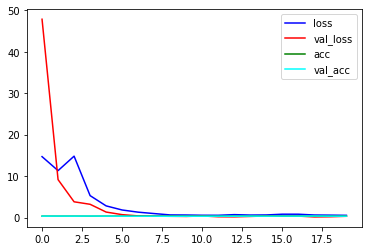

In [ ]:

import matplotlib.pyplot as plt

print(history.history)
plt.plot(history.history['loss'], label='loss', color='b')
plt.plot(history.history['val_loss'], label='val_loss', color='r')

plt.plot(history.history['accuracy'], label='acc', color='g')
plt.plot(history.history['val_accuracy'], label='val_acc', color='cyan')

plt.legend()

In [ ]:
import IPython

print(model.summary())

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attn_mask (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_for_masked_lm_15 (TFBe  TFMaskedLMOutput(lo  109112880  ['input_ids[0][0]',              
 rtForMaskedLM)                 ss=None, logits=(No               'attn_mask[0][0]']              
                                ne, 512, 30000),                                                  
                                 hidden_states=None                                        

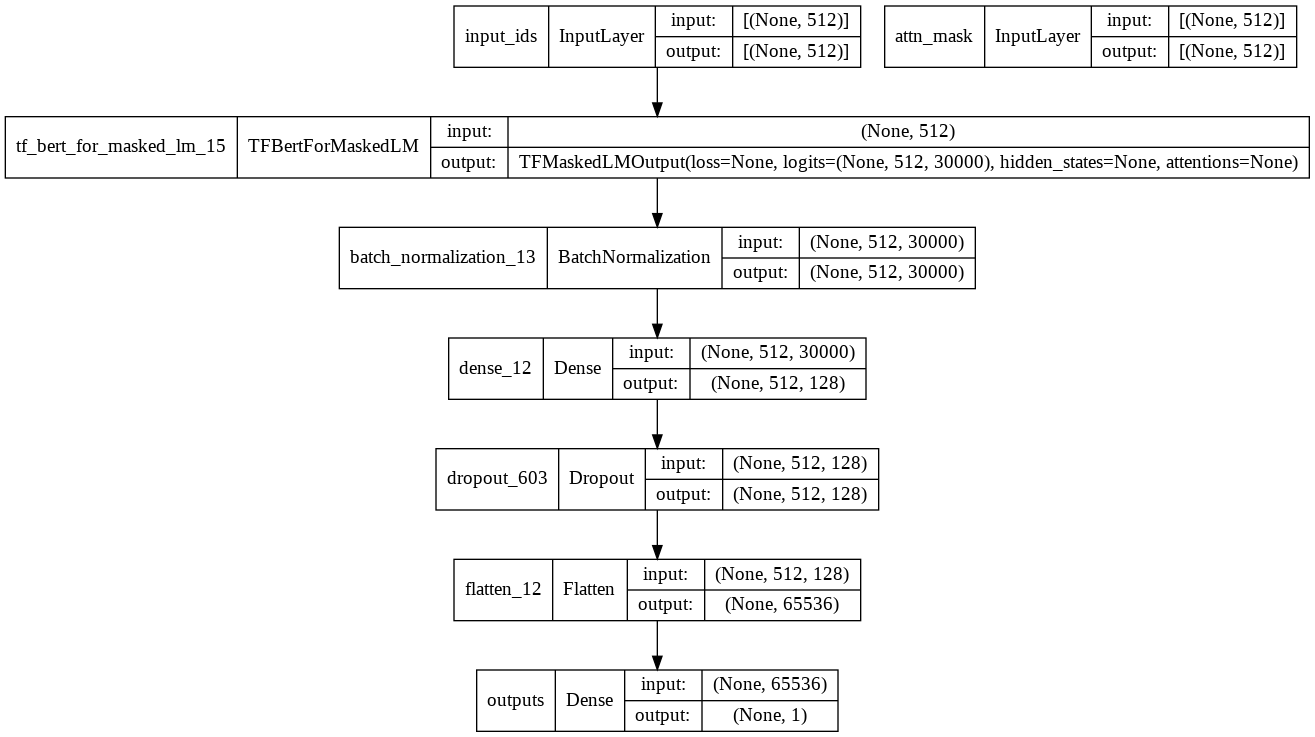

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def build_model(seq_len):
    
    input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(seq_len,), name='attn_mask', dtype='int32')

    bert_model = TFAutoModelForMaskedLM.from_pretrained("bert-base-german-cased")

    X = bert_model(input_ids, attention_mask=mask)
    X = X[0]
    X = tf.keras.layers.BatchNormalization()(X)


    X = tf.keras.layers.Conv1D(64, (4,), padding='same',  activation='relu')(X)
    X = tf.keras.layers.MaxPooling1D(2,)(X)
    
    X = tf.keras.layers.Conv1D(128, (4,), padding='same',  activation='relu')(X)
    X = tf.keras.layers.MaxPooling1D(2,)(X)

    X = tf.keras.layers.Conv1D(256, (4,), padding='same',  activation='relu')(X)
    X = tf.keras.layers.MaxPooling1D(2,)(X)

    X = tf.keras.layers.Dense(128, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.1)(X)
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(512, activation='relu')(X)
    X = tf.keras.layers.Dense(64, activation='relu')(X)
    X = tf.keras.layers.Dense(8, activation='relu')(X)
    y = tf.keras.layers.Dense(1, activation='softmax', name='outputs')(X)

    model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

    bert_model.trainable = False
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model


def create_model():
    return build_model(SEQUENCE_LENGTH)


m1 = create_model()


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


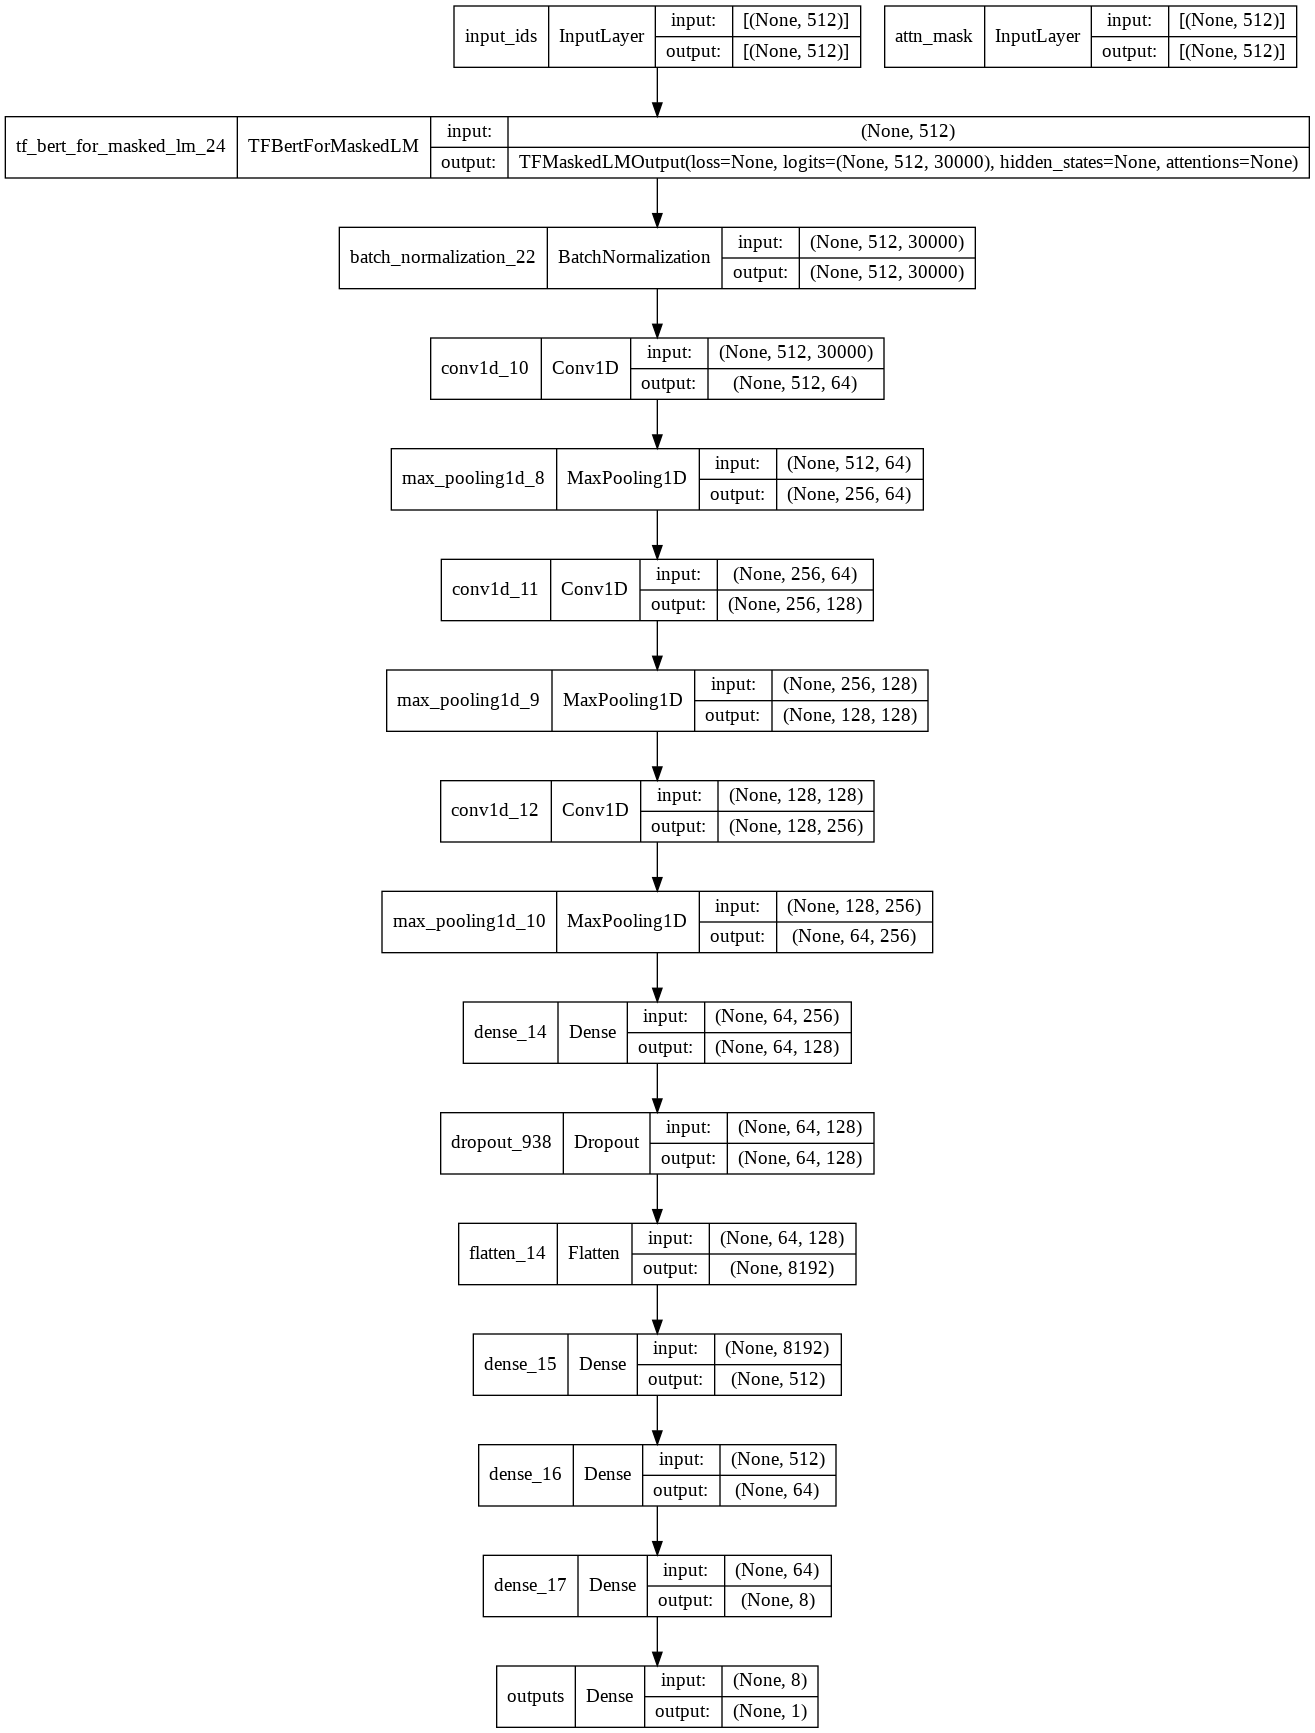

In [ ]:

tf.keras.utils.plot_model(m1, show_shapes=True)

In [ ]:
print(m1.summary())

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attn_mask (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_for_masked_lm_24 (TFBe  TFMaskedLMOutput(lo  109112880  ['input_ids[0][0]',              
 rtForMaskedLM)                 ss=None, logits=(No               'attn_mask[0][0]']              
                                ne, 512, 30000),                                                  
                                 hidden_states=None                                        